In [1]:
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras import backend as K
from skimage.transform import resize
import os
# from cv2 import imread, cvtColor, COLOR_BGR2RGB
from imageio import imread

%matplotlib inline

Using TensorFlow backend.


In [2]:
K.image_data_format()

'channels_last'

In [3]:
cdir = "D:/Desktop/Cursovaya/2019/AutoEncoders"
cat_folder = "../kagglecatsanddogs_3367a/PetImages/Cat"
dog_folder = "../kagglecatsanddogs_3367a/PetImages/Dog"

In [4]:
def count_samples(folder: int) -> int:
    return len(list(filter(lambda a: a.endswith(".jpg"), os.listdir(folder))))

In [40]:
def img_generator(folder: int, shape: tuple) -> np.array:
    fnames = list(filter(lambda a: a.endswith(".jpg"), os.listdir(folder)))
    for name in fnames:
        try:
            file = "/".join([folder, name])
            img = imread(file)
            img = img[:, :, :3]
            img = resize(img, shape, mode="reflect", anti_aliasing=True)
            if img.shape != (*shape, 3):
                continue
            yield img
        except (EOFError, IndexError, ValueError):
            print("\n", name)
            continue

In [47]:
def img_batch_generator(folder: str, batch_size: int, shape: tuple) -> np.array:
    batch = []
    gen = img_generator(folder, shape)
    for img in gen:
        batch.append(img)
        if len(batch) == batch_size:
            ret = np.array(batch)
            yield ret
            batch = []
#     yield np.array(batch)

In [48]:
def add_gaussian_noise(imgs: np.array) -> np.array:
    return np.clip(imgs + np.random.normal(size=imgs.shape, scale=0.1), 0, 1)

In [49]:
def test_noise(noise_func, imgs):
    print("Testing", noise_func.__name__)
    n_img = len(imgs)
    noised = noise_func(imgs)
    f, ax = plt.subplots(n_img, 2, sharey=True)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i in range(n_img):
        ax1 = ax[i][0]
        ax2 = ax[i][1]
        ax1.imshow(imgs[i])
        ax2.imshow(noised[i])

In [50]:
g = img_batch_generator(cat_folder, 5, (64, 64))

Testing add_gaussian_noise


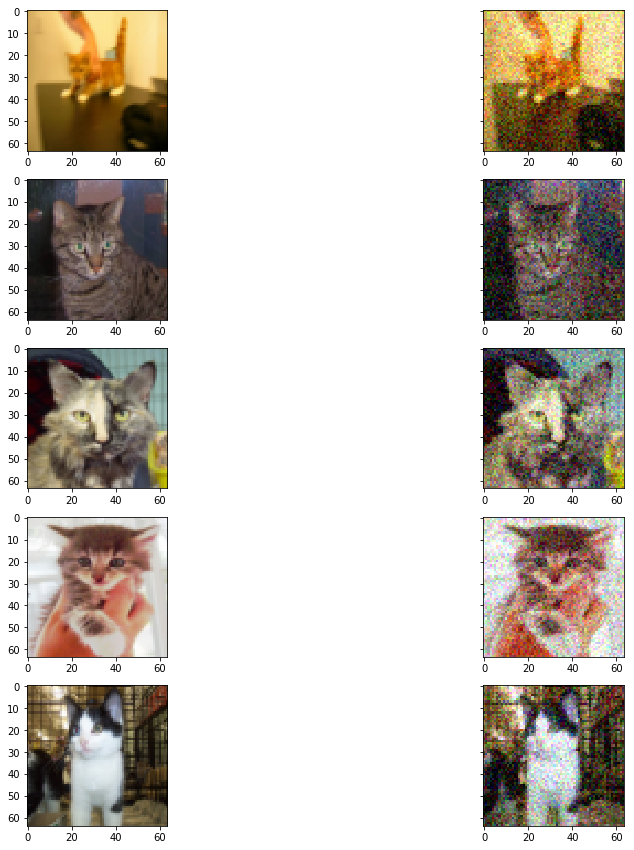

In [51]:
test_noise(add_gaussian_noise, next(g))

In [32]:
def infinite_AE_generator(folder, batch_size, noise_func, shape) -> np.array:
    while True:
        gen = img_batch_generator(folder, batch_size, shape)
        for data in gen:
            yield noise_func(data), data

In [21]:
def create_nn(data_folder: str, 
              batch_size: int, 
              epochs:int, 
              steps_per_epoch: int, 
              noise_func, 
              img_shape: tuple):
    K.clear_session()
    nn = Sequential()
    inp_shape = (*img_shape, 3)
    nn.add(Conv2D(16, (3, 3), 
                  padding="same", 
                  activation="relu", 
                  input_shape=inp_shape, 
                  data_format='channels_last'))
    nn.add(MaxPooling2D((2, 2), padding='same'))
    nn.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    nn.add(MaxPooling2D((2, 2), padding='same'))
    nn.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    nn.add(MaxPooling2D((2, 2), padding='same'))

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    nn.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    nn.add(UpSampling2D((2, 2)))
    nn.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    nn.add(UpSampling2D((2, 2)))
    nn.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    nn.add(UpSampling2D((2, 2)))
    nn.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    nn.compile(optimizer="RMSProp", loss="binary_crossentropy")
    print(nn.summary())
    gen = infinite_AE_generator(data_folder, batch_size=batch_size, noise_func=noise_func, shape=img_shape)
    nn.fit_generator(gen, steps_per_epoch=steps_per_epoch, epochs=epochs,)
    return nn

In [46]:
folder = cat_folder
batch_size = 5
epochs = 1
img_shape = (64, 64)
steps_per_epoch = count_samples(cat_folder) / batch_size
noise_func = add_gaussian_noise
model = create_nn(folder, 
                  epochs=epochs,
                  batch_size=batch_size, 
                  steps_per_epoch=steps_per_epoch, 
                  noise_func=noise_func, 
                  img_shape=img_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 8)           584       
__________

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15073280 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


  90/2500 [>.............................] - ETA: 6:40 - loss: 0.6396
 10404.jpg
 166/2500 [>.............................] - ETA: 6:07 - loss: 0.6205

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXI

 243/2500 [=>............................] - ETA: 5:46 - loss: 0.6117
 11095.jpg
 447/2500 [====>.........................] - ETA: 5:09 - loss: 0.5997

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2097152 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1245184 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 13107200 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1966080 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF d

 462/2500 [====>.........................] - ETA: 5:06 - loss: 0.5990
 12080.jpg
 494/2500 [====>.........................] - ETA: 4:58 - loss: 0.5976

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 363331584 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 729604 bytes but only got 5921. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262400 bytes but only got 5921. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 543/2500 [=====>........................] - ETA: 4:48 - loss: 0.5958

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


 615/2500 [======>.......................] - ETA: 4:34 - loss: 0.5945

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 310640640 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 729604 bytes but only got 5117. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262400 bytes but only got 5117. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 766/2500 [========>.....................] - ETA: 4:09 - loss: 0.5920

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 35520512 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19988480 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2271805440 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 930/2500 [==========>...................] - ETA: 3:45 - loss: 0.5896
 2939.jpg
1014/2500 [===========>..................] - ETA: 3:33 - loss: 0.5889

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


1418/2500 [================>.............] - ETA: 2:33 - loss: 0.5853

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 5357. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corr

1470/2500 [================>.............] - ETA: 2:25 - loss: 0.5846
 5370.jpg
1540/2500 [=================>............] - ETA: 2:16 - loss: 0.5841
 5686.jpg
1706/2500 [===================>..........] - ETA: 1:53 - loss: 0.5829
 6435.jpg
1756/2500 [====================>.........] - ETA: 1:47 - loss: 0.5826
 666.jpg
1893/2500 [=====================>........] - ETA: 1:28 - loss: 0.5819
 7276.jpg
1904/2500 [=====================>........] - ETA: 1:26 - loss: 0.5818

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


1978/2500 [======================>.......] - ETA: 1:15 - loss: 0.5813

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7922004686 bytes but only got 0. Skipping tag 28243
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2454581108 bytes but only got 0. Skipping tag 60655
  " Skipping tag %s" % (size, len(data), tag))


2121/2500 [========================>.....] - ETA: 54s - loss: 0.5804

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1329790976 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7168 bytes but only got 4018. Skipping tag 22528
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1024000 bytes but only got 6578. Skipping tag 39424
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 16843011 bytes but only got 0. Skipping tag 2826
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possib

2158/2500 [========================>.....] - ETA: 49s - loss: 0.5802
 8470.jpg
2175/2500 [=========================>....] - ETA: 46s - loss: 0.5801

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2891758495 bytes but only got 0. Skipping tag 26356
  " Skipping tag %s" % (size, len(data), tag))


2498/2500 [============================>.] - ETA: 0s - loss: 0.5788

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (0, 1)